In [1]:
# Load libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [2]:
# Get training and testing data
train_data = pd.read_csv("train_data.csv", delimiter='\t', index_col=0)
test_data  = pd.read_csv("test_data.csv", delimiter='\t', index_col=0)
# Drop ID, chocolate, the ficticious drug Semer, and legal substances
train_data.drop(columns=['ID', 'Choc', 'Semer', 'Alcohol', 'Nicotine', 'Caff', 'Legalh'], inplace=True)
test_data.drop (columns=['ID', 'Choc', 'Semer', 'Alcohol', 'Nicotine', 'Caff', 'Legalh'], inplace=True)

# Convert categories to integers
for column in train_data.loc[:, 'Amphet':]:
    train_data[column] = train_data[column].astype('category').cat.codes
    train_data[column] = train_data[column].astype('int32')
for column in test_data.loc[:, 'Amphet':]:
    test_data[column]  = test_data[column].astype('category').cat.codes
    test_data[column]  = test_data[column].astype('int32')

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319 entries, 1287 to 684
Data columns (total 25 columns):
Age          1319 non-null float64
Gender       1319 non-null float64
Education    1319 non-null float64
Country      1319 non-null float64
Ethnicity    1319 non-null float64
Nscore       1319 non-null float64
Escore       1319 non-null float64
Oscore       1319 non-null float64
Ascore       1319 non-null float64
Cscore       1319 non-null float64
Impulsive    1319 non-null float64
SS           1319 non-null float64
Amphet       1319 non-null int32
Amyl         1319 non-null int32
Benzos       1319 non-null int32
Cannabis     1319 non-null int32
Coke         1319 non-null int32
Crack        1319 non-null int32
Ecstacy      1319 non-null int32
Heroin       1319 non-null int32
Ketamine     1319 non-null int32
LSD          1319 non-null int32
Meth         1319 non-null int32
Mushrooms    1319 non-null int32
VSA          1319 non-null int32
dtypes: float64(12), int32(13)
memory usag

In [3]:
def is_drug_user(row):
    row = row['Amphet':]
    num_zeros = (row == 0).astype(bool).sum()
    if num_zeros == row.size:
        return False
    return True

# Add 'Drug User' column
train_data['Drug User'] = train_data.apply(is_drug_user, axis=1)
test_data['Drug User']  = test_data.apply (is_drug_user, axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319 entries, 1287 to 684
Data columns (total 26 columns):
Age          1319 non-null float64
Gender       1319 non-null float64
Education    1319 non-null float64
Country      1319 non-null float64
Ethnicity    1319 non-null float64
Nscore       1319 non-null float64
Escore       1319 non-null float64
Oscore       1319 non-null float64
Ascore       1319 non-null float64
Cscore       1319 non-null float64
Impulsive    1319 non-null float64
SS           1319 non-null float64
Amphet       1319 non-null int32
Amyl         1319 non-null int32
Benzos       1319 non-null int32
Cannabis     1319 non-null int32
Coke         1319 non-null int32
Crack        1319 non-null int32
Ecstacy      1319 non-null int32
Heroin       1319 non-null int32
Ketamine     1319 non-null int32
LSD          1319 non-null int32
Meth         1319 non-null int32
Mushrooms    1319 non-null int32
VSA          1319 non-null int32
Drug User    1319 non-null bool
dtypes: bo

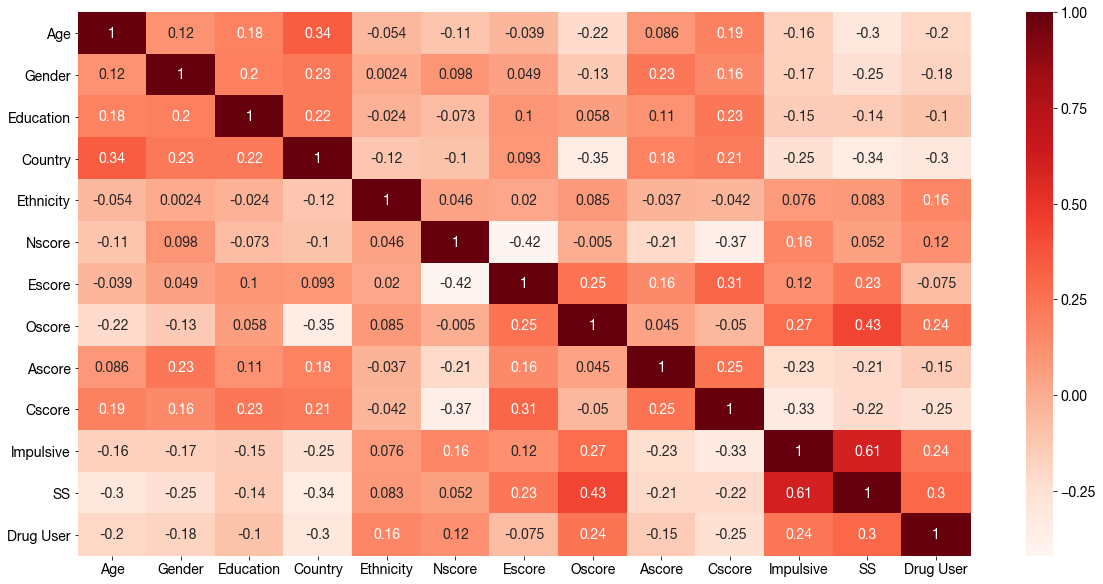

Relevant variables (corr > 0.192): ['Age' 'Country' 'Oscore' 'Cscore' 'Impulsive' 'SS']


In [4]:
# Examine input variables
matplotlib.rc('font', family='Helvetica Neue', size=14)
fig  = plt.gcf()
fig.set_size_inches(20, 10)
corr = train_data.drop(columns=['Amphet',
                                'Amyl',
                                'Benzos',
                                'Cannabis',
                                'Coke',
                                'Crack',
                                'Ecstacy',
                                'Heroin',
                                'Ketamine',
                                'LSD',
                                'Meth',
                                'Mushrooms',
                                'VSA']).corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

# Correlation with output variable
corr_target = abs(corr['Drug User'])

# Select relevant variables
variables   = corr_target[corr_target > corr_target.loc['Age':'SS'].median()]
variables   = variables.loc['Age':'SS'].index.values
var_indices = [train_data.columns.get_loc(variable) for variable in variables]
print('Relevant variables (corr > %.3f):'%corr_target.loc['Age':'SS'].median(), variables)

In [5]:
x_train = train_data.drop('Drug User', axis=1)
x_test  = test_data.drop ('Drug User', axis=1)
y_train = train_data['Drug User']
y_test  = test_data ['Drug User']

# Standardize training and testing data
scaler         = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.fit_transform(x_test)

In [6]:
# Build a decision tree classifier to classify people as drug users or non-users
classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier.fit(x_train_scaled[:, var_indices], y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [7]:
# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[(  1,  88,  1,  0.37104077, 0.61578458, 1319, 1.319e+03)
 (  2,  33,  1, -1.03708935, 0.21804385,  603, 6.030e+02)
 (  3,   4,  3, -0.71024391, 0.09916557,  389, 3.890e+02)
 ( -1,  -1, -2, -2.        , 0.        ,  124, 1.240e+02)
 (  5,   6,  4, -0.48617859, 0.1350362 ,  265, 2.650e+02)
 ( -1,  -1, -2, -2.        , 0.        ,   66, 6.600e+01)
 (  7,  16,  0, -0.6268507 , 0.16932446,  199, 1.990e+02)
 (  8,   9,  2,  1.30229104, 0.07360348,  112, 1.120e+02)
 ( -1,  -1, -2, -2.        , 0.        ,   89, 8.900e+01)
 ( 10,  15,  2,  1.5078187 , 0.25801867,   23, 2.300e+01)
 ( 11,  12,  4,  0.75859267, 0.54356444,    8, 8.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    6, 6.000e+00)
 ( 13,  14,  3,  0.49862912, 1.        ,    2, 2.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,   15, 1.500e+01)
 ( 17,  30,  3,  1.46841699, 0.2690553 ,   87, 8.700e+01)
 ( 18,  25,  5

475

In [8]:
# The mean accuracy and the 95% confidence interval of 10-fold cross validation
scores = cross_val_score(classifier, x_train_scaled[:, var_indices], y_train,
                         cv=10, scoring='accuracy')
print('Accuracy: %0.3f (+/- %0.3f)'%(scores.mean(), scores.std() * 2))

# The mean F1 score and the 95% confidence interval of 10-fold cross validation
scores = cross_val_score(classifier, x_train_scaled[:, var_indices], y_train,
                         cv=10, scoring='f1')
print('F1 score: %0.3f (+/- %0.3f)'%(scores.mean(), scores.std() * 2))

Accuracy: 0.790 (+/- 0.082)
F1 score: 0.874 (+/- 0.054)


In [9]:
# Feature importances (aka Gini importance)
count = 0
print('Gini importance:')
for (variable, feature_importance) in sorted(zip(variables,
    classifier.feature_importances_), key=lambda x: x[1], reverse=True):
    count += 1
    print('(%d)' % count, '%0.3f:'%feature_importance, variable)

Gini importance:
(1) 0.243: Cscore
(2) 0.203: Oscore
(3) 0.173: SS
(4) 0.135: Country
(5) 0.131: Age
(6) 0.115: Impulsive


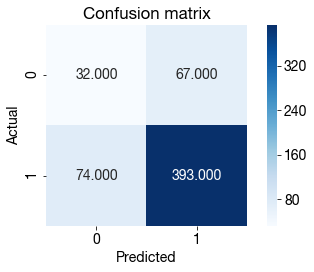

In [10]:
# Predict the class labels for the test set using the decision tree classifier
y_pred = classifier.predict(x_test_scaled[:, var_indices])

# Plot the corresponding confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='.3f', square=True, cmap=plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [11]:
# Compute evaluation metrics for the decision tree classifier
accuracy  = metrics.accuracy_score(y_test, y_pred)
error     = 1 - metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average=None)
recall    = metrics.recall_score(y_test, y_pred, average=None)
f1_score  = metrics.f1_score(y_test, y_pred, average=None)
print('Accuracy:  ', '%0.3f'%accuracy)
print('Error:     ', '%0.3f'%error)
print('Precision: ', '[%0.3f'%precision[0], '%0.3f]'%precision[1])
print('Recall:    ', '[%0.3f'%recall[0],    '%0.3f]'%recall[1])
print('F1 score:  ', '[%0.3f'%f1_score[0],  '%0.3f]'%f1_score[1])

Accuracy:   0.751
Error:      0.249
Precision:  [0.302 0.854]
Recall:     [0.323 0.842]
F1 score:   [0.312 0.848]


In [12]:
# Build a k-nearest neighbors classifier to classify people as drug users or non-users
classifier = KNeighborsClassifier(n_neighbors=3) 
classifier.fit(x_train_scaled[:, var_indices], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [13]:
# The mean accuracy and the 95% confidence interval of 10-fold cross validation
scores = cross_val_score(classifier, x_train_scaled[:, var_indices], y_train,
                         cv=10, scoring='accuracy')
print('Accuracy: %0.3f (+/- %0.3f)'%(scores.mean(), scores.std() * 2))

# The mean F1 score and the 95% confidence interval of 10-fold cross validation
scores = cross_val_score(classifier, x_train_scaled[:, var_indices], y_train,
                         cv=10, scoring='f1')
print('F1 score: %0.3f (+/- %0.3f)'%(scores.mean(), scores.std() * 2))

Accuracy: 0.809 (+/- 0.060)
F1 score: 0.888 (+/- 0.037)


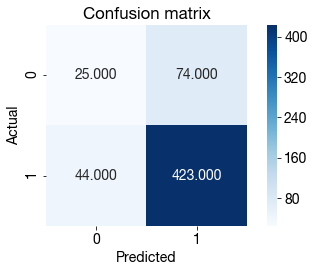

In [14]:
# Predict the class labels for the test set using the decision tree classifier
y_pred = classifier.predict(x_test_scaled[:, var_indices])

# Plot the corresponding confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='.3f', square=True, cmap=plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [15]:
# Compute evaluation metrics for the decision tree classifier
accuracy  = metrics.accuracy_score(y_test, y_pred)
error     = 1 - metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average=None)
recall    = metrics.recall_score(y_test, y_pred, average=None)
f1_score  = metrics.f1_score(y_test, y_pred, average=None)
print('Accuracy:  ', '%0.3f'%accuracy)
print('Error:     ', '%0.3f'%error)
print('Precision: ', '[%0.3f'%precision[0], '%0.3f]'%precision[1])
print('Recall:    ', '[%0.3f'%recall[0],    '%0.3f]'%recall[1])
print('F1 score:  ', '[%0.3f'%f1_score[0],  '%0.3f]'%f1_score[1])

Accuracy:   0.792
Error:      0.208
Precision:  [0.362 0.851]
Recall:     [0.253 0.906]
F1 score:   [0.298 0.878]
